<h1>Imports<h1>

In [1]:
import os
os.chdir("..")
print(os.getcwd())

/work/lurny/files/Thesis


In [2]:
from utilities.configs import *
config_1 = get_config_for_dataset('rbf_m')

In [3]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
#from pydl85 import DL85Classifier

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

if config_1['computation']['use_gpu']:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config_1['computation']['gpu_numbers'])
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-11.6"
    os.environ['TF_XLA_FLAGS'] = "--tf_xla_enable_xla_devices --tf_xla_auto_jit=2"    
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false' 
#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_GDT import *
from utilities.GDT_for_streams import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy
from pathlib import Path
import pickle
import dill

from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from livelossplot import PlotLosses
import time

tf.random.set_seed(config_1['computation']['random_seed'])
np.random.seed(config_1['computation']['random_seed'])
random.seed(config_1['computation']['random_seed'])

from datetime import datetime
timestr = datetime.utcnow().strftime('%Y-%m-%d--%H-%M-%S%f')
print(timestr)
os.makedirs(os.path.dirname("./evaluation_results/latex_tables/" + timestr +"/"), exist_ok=True)

filepath = './evaluation_results/depth' + str(config_1['gdt']['depth']) + '/' + timestr + '/'
Path(filepath).mkdir(parents=True, exist_ok=True)    


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

2023-01-20--17-46-27606154


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


In [5]:
import math
def split_df_chunks(data_df,chunk_size):
    total_length     = len(data_df)
    normal_chunk_num = math.floor(total_length/chunk_size)
    chunks = []
    for i in range(normal_chunk_num):
        chunk = data_df[(i*chunk_size):((i+1)*chunk_size)]
        chunks.append(chunk)

    return chunks

# Evaluation of agr_a dataset

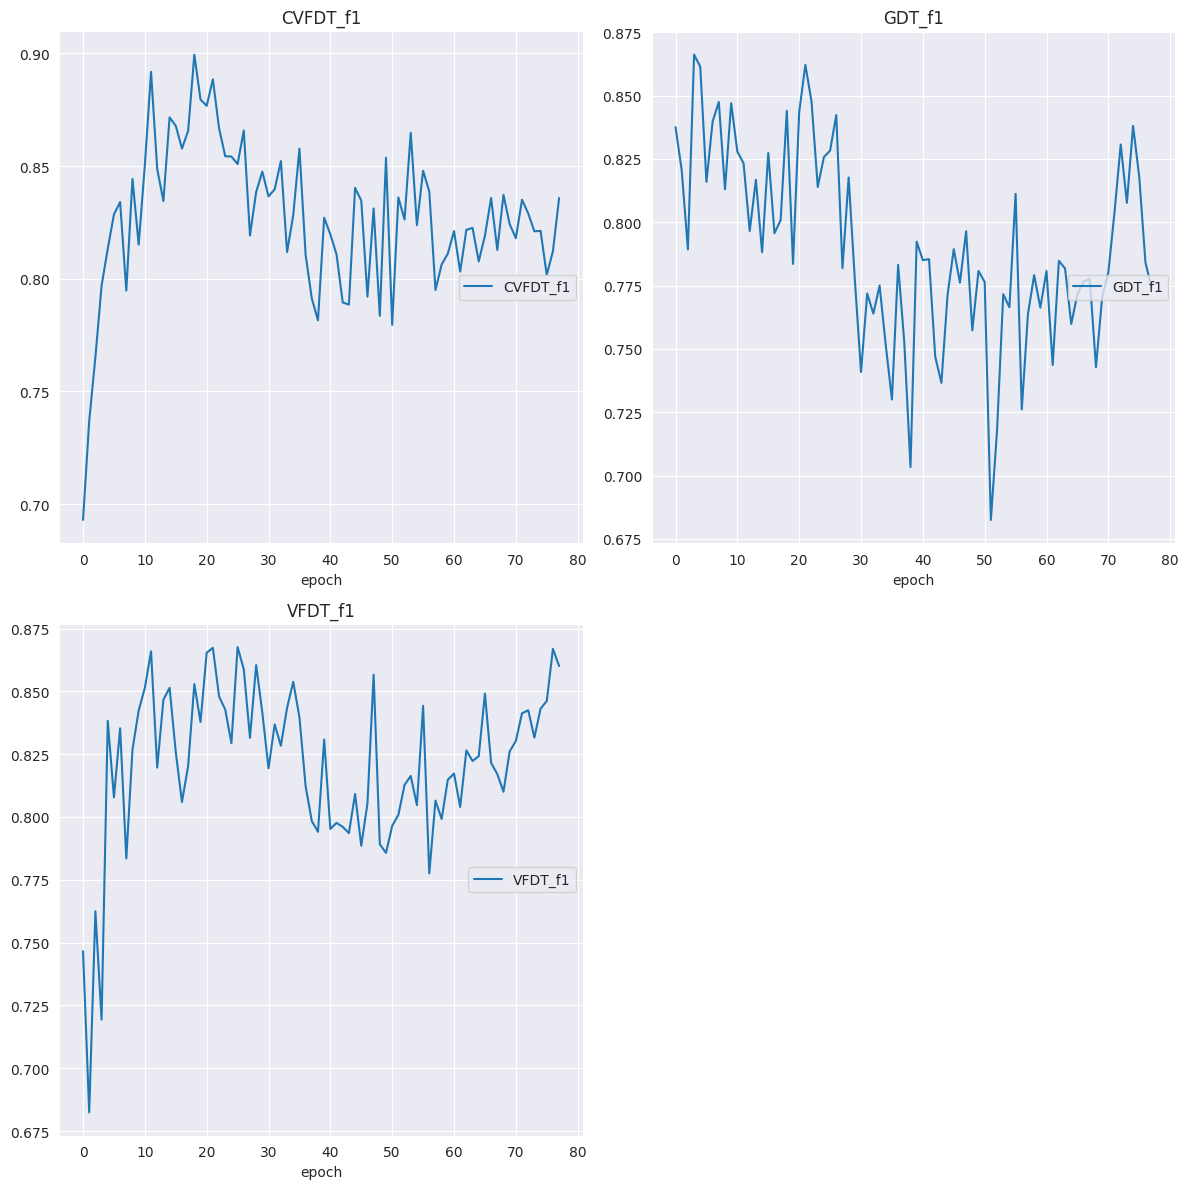

CVFDT_f1
	CVFDT_f1         	 (min:    0.693, max:    0.899, cur:    0.836)
GDT_f1
	GDT_f1           	 (min:    0.683, max:    0.866, cur:    0.774)
VFDT_f1
	VFDT_f1          	 (min:    0.682, max:    0.868, cur:    0.860)
Original Data Shape (selected):  (2500, 10)
Original Data Shape (encoded):  (2500, 10)
Original Data Class Distribution:  1261  (true) / 1239  (false)
(1500, 10) (1500,)
(500, 10) (500,)
(500, 10) (500,)
Min Ratio:  0.49333333333333335
Min Ratio:  0.4865


restarts:   0%|          | 0/1 [00:00<?, ?it/s]

epochs:   0%|          | 0/1 [00:00<?, ?it/s]

<tf.Variable 'Adam_2/learning_rate:0' shape=() dtype=float32>
<tf.Variable 'Adam_2/learning_rate:0' shape=() dtype=float32>


In [ ]:
from sklearn.metrics import cohen_kappa_score
#'NOAA_Weather','agr_a','agr_g','airlines','electricity','hyperplane','rbf_f','rbf_m','sea_a','sea_g'
dataset_names = ['rbf_1', 'rbf_2', 'rbf_3', 'rbf_4', 'rbf_5']
for dataset_name in dataset_names:
    config = get_config_for_dataset('rbf_f')#dataset_name

    VFDT_classifier = HoeffdingTreeClassifier()
    CVFDT_classifier = HoeffdingAdaptiveTreeClassifier()

    config_training, metrics = prepare_training_for_streams(identifier = 'BIN:'+dataset_name, config = config)
    #load Dataset
    X_data, y_data, nominal_features, ordinal_features = load_dataset_for_streams(identifier = 'BIN:'+dataset_name, 
                                                                              max_total_samples = config['computation']['max_total_samples'])

    model_dict = {}
    scores_dict = {}
    normalizer_list = []
    plotlosses_benchmark = PlotLosses()
    verbosity = 1
    model_dict['GDT'] = GDT(number_of_variables = len(X_data.columns),
                number_of_classes = len(np.unique(y_data)),#dataset_dict['number_of_classes'],

                objective = config_training['gdt']['objective'],

                depth = config_training['gdt']['depth'],

                learning_rate_index = config_training['gdt']['learning_rate_index'],
                learning_rate_values = config_training['gdt']['learning_rate_values'],
                learning_rate_leaf = config_training['gdt']['learning_rate_leaf'],

                optimizer = config_training['gdt']['optimizer'],

                loss = 'crossentropy',

                initializer_values = config_training['gdt']['initializer_values'],
                initializer_index = config_training['gdt']['initializer_index'],
                initializer_leaf = config_training['gdt']['initializer_leaf'],        

                random_seed = config_training['computation']['random_seed'],
                verbosity = verbosity)  


    #Pretraing
    if(config_training['computation']['pretrain_size']>0 and len(X_data) > config_training['computation']['pretrain_size']):
        X_pretrain_data = X_data.iloc[:config_training['computation']['pretrain_size'],:]
        X_data = X_data.iloc[config_training['computation']['pretrain_size']:,:]
        y_pretrain_data = y_data.iloc[:config_training['computation']['pretrain_size']]
        y_data = y_data.iloc[config_training['computation']['pretrain_size']:]

        ((X_train, y_train),
         (X_valid, y_valid),
         (X_test, y_test),
         (X_train_with_valid, y_train_with_valid),
         normalizer_list) = preprocess_data(X_pretrain_data, 
                                           y_pretrain_data,
                                           nominal_features,
                                           ordinal_features,
                                           config_training,
                                           normalizer_list,
                                           random_seed= 42,#random_seed,
                                           verbosity=1)#verbosity)  
        dataset_dict = {
               'X_train': X_train,
               'y_train': y_train,
               'X_valid': X_valid,
               'y_valid': y_valid,
               'X_test': X_test,
               'y_test': y_test,
               'normalizer_list': normalizer_list
               }



        model_dict['GDT'].partial_fit(dataset_dict['X_train'],
                  dataset_dict['y_train'],
                  batch_size=config_training['gdt']['batch_size'], 
                  epochs=config_training['gdt']['pretrain_epochs'], 
                  restarts = 0,#config_test['gdt']['restarts'], 
                  #restart_type=config_test['gdt']['restart_type'], 
                  #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
                  #early_stopping_type=config_test['gdt']['early_stopping_type'],
                  valid_data=(dataset_dict['X_valid'],dataset_dict['y_valid']))

        #pretrain benchmarks
        temp_X_train =X_train_with_valid.values
        temp_y_train =y_train_with_valid.values
        for i in range(0, len(dataset_dict['X_train'])):
            VFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64)) 
            CVFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))






    #prepare Stream
    X_data_stream = split_df_chunks(X_data, config['computation']['chunk_size'])
    y_data_stream = split_df_chunks(y_data, config['computation']['chunk_size'])

    scores_GDT = {'f1':np.array([]),
                  'acc':np.array([]),
                  'kappa':np.array([])
                 }
    scores_VFDT = {'f1':np.array([]),
                  'acc':np.array([]),
                  'kappa':np.array([])
                 }
    scores_CVFDT = {'f1':np.array([]),
                  'acc':np.array([]),
                  'kappa':np.array([])
                 }
    timer = {'training':{
                'GDT':0.0,
                'VFDT':0.0,
                'CVFDT':0.0,
             },
             'prediction':{
                'GDT':0.0,
                'VFDT':0.0,
                'CVFDT':0.0,
             }
            }
    flag = False;

    #Start Stream
    for i in range(len(X_data_stream)):
        normalizer_list=[]
        ((X_train, y_train),
         (X_valid, y_valid),
         (X_test, y_test),
         (X_train_with_valid, y_train_with_valid),
         normalizer_list) = preprocess_data(X_data_stream[i], 
                                           y_data_stream[i],
                                           nominal_features,
                                           ordinal_features,
                                           config_training,
                                           normalizer_list,
                                           random_seed= 42,#random_seed,
                                           verbosity=1)#verbosity)  
        dataset_dict = {
               'X_train': X_train,
               'y_train': y_train,
               'X_valid': X_valid,
               'y_valid': y_valid,
               'X_test': X_test,
               'y_test': y_test,
               'normalizer_list': normalizer_list
               }  


        t0 = time.time()
        #if(i==491):
        #    flag = True
        history = model_dict['GDT'].partial_fit(dataset_dict['X_train'],
                  dataset_dict['y_train'],

                  batch_size=config_training['gdt']['batch_size'], 
                  epochs=config_training['gdt']['epochs'], 

                  restarts = 0,
                  drift_flag = flag,
                  #config_test['gdt']['restarts'], 
                  #restart_type=config_test['gdt']['restart_type'], 

                  #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
                  #early_stopping_type=config_test['gdt']['early_stopping_type'],

                  valid_data=(dataset_dict['X_valid'],dataset_dict['y_valid']))
        flag=False
        t1 = time.time()
        timer['training']['GDT'] = timer['training']['GDT']+t1-t0


        ###EVALUATION
        y_test_data = dataset_dict['y_test'].values
        temp_X_test = dataset_dict['X_test'].values

        temp_X_train =X_train_with_valid.values
        temp_y_train =y_train_with_valid.values


        t0 = time.time()
        #GDT
        metric = "f1"
        y_test_data = dataset_dict['y_test']
        y_pred_GDT = model_dict['GDT'].predict(enforce_numpy(temp_X_test))
        y_pred_GDT = np.nan_to_num(y_pred_GDT)
        y_pred_GDT = np.round(y_pred_GDT)
        #GDT_f1 = sklearn.metrics.get_scorer(metric)._score_func(y_pred_GDT, y_test, average='weighted')
        GDT_f1 = f1_score(y_test_data, y_pred_GDT)
        GDT_acc = accuracy_score(y_test_data, y_pred_GDT)
        GDT_kappa = cohen_kappa_score(y_test_data,y_pred_GDT)

        t1 = time.time()
        timer['prediction']['GDT'] = timer['prediction']['GDT']+t1-t0


        #VFDT
        t0 = time.time()
        y_pred_VFDT = []
        for i in range(0, len(temp_X_train)):
            VFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))
        t1 = time.time()
        timer['training']['VFDT'] = timer['training']['VFDT']+t1-t0

        t0 = time.time()
        for i in range(0, len(dataset_dict['X_test'])):
            y_pred_VFDT.append(VFDT_classifier.predict(np.array([temp_X_test[i]], np.float64))[0])  
        VFDT_f1 = f1_score(y_test_data, y_pred_VFDT)
        VFDT_acc = accuracy_score(y_test_data, y_pred_VFDT)
        VFDT_kappa = cohen_kappa_score(y_test_data,y_pred_VFDT)
        t1 = time.time()
        timer['prediction']['VFDT'] = timer['prediction']['VFDT']+t1-t0

        #CVFDT
        t0 = time.time()
        y_pred_CVFDT = []
        for i in range(0, len(dataset_dict['X_train'])):
            CVFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))
        t1 = time.time()
        timer['training']['CVFDT'] = timer['training']['CVFDT']+t1-t0

        t0 = time.time()
        for i in range(0, len(dataset_dict['X_test'])):
            y_pred_CVFDT.append(CVFDT_classifier.predict(np.array([temp_X_test[i]], np.float64))[0])  
        CVFDT_f1 = f1_score(y_test_data, y_pred_CVFDT)
        CVFDT_acc = accuracy_score(y_test_data, y_pred_CVFDT)
        CVFDT_kappa = cohen_kappa_score(y_test_data,y_pred_CVFDT)
        t1 = time.time()
        timer['prediction']['CVFDT'] = timer['prediction']['CVFDT']+t1-t0



        plotlosses_benchmark.update({'GDT_f1': GDT_f1,'VFDT_f1': VFDT_f1, 'CVFDT_f1':CVFDT_f1})
        plotlosses_benchmark.send() 


        scores_GDT['f1'] = np.append(scores_GDT['f1'], GDT_f1)
        scores_VFDT['f1'] = np.append(scores_VFDT['f1'], VFDT_f1)
        scores_CVFDT['f1'] = np.append(scores_CVFDT['f1'], CVFDT_f1)

        scores_GDT['acc'] = np.append(scores_GDT['acc'], GDT_acc)
        scores_VFDT['acc'] = np.append(scores_VFDT['acc'], VFDT_acc)
        scores_CVFDT['acc'] = np.append(scores_CVFDT['acc'], CVFDT_acc)

        scores_GDT['kappa'] = np.append(scores_GDT['kappa'], GDT_kappa)
        scores_VFDT['kappa'] = np.append(scores_VFDT['kappa'], VFDT_kappa)
        scores_CVFDT['kappa'] = np.append(scores_CVFDT['kappa'], CVFDT_kappa)


    #save_scores(dataset_name, scores_GDT, scores_VFDT, scores_CVFDT, VFDT_classifier, CVFDT_classifier, config, timer)
    results = pd.DataFrame(columns=['Metric','Dataset', 'GDT', 'VFDT', 'CVFDT'])
    results.loc[len(results)] =['Kappa',dataset_name,round(np.mean(scores_GDT['kappa']),4),round(np.mean(scores_VFDT['kappa']),4),round(np.mean(scores_CVFDT['kappa']),4)]
    results.to_csv('results/rbf_speed/'+dataset_name+'.csv')

In [ ]:
#Plot results
X = np.arange(0, len(scores_GDT['f1']), 1)
  
# Assign variables to the y axis part of the curve
#plt.rc('text', usetex=True)
#plt.rc('font', family = 'Computer Modern')
  
# Plotting both the curves simultaneously
plt.plot(X, scores_GDT['f1'], color='r', label='GDT_f1', linewidth=1)
plt.plot(X, scores_VFDT['f1'], color='g', label='VFDT_f1', linewidth=1)
plt.plot(X, scores_CVFDT['f1'], color='y', label='CVFDT_f1', linewidth=1)

#plt.axes().set_facecolor("white")

  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Chunks")
plt.ylabel("F1 score")
plt.title("Dataset: " + dataset_name)
plt.legend()
plt.show()

print("median GDT F1: " + str(round(np.median(scores_GDT['f1']),4)) + "       avg: " +str(round(np.average(scores_GDT['f1']),4)))
print("median VFDT F1: " + str(round(np.median(scores_VFDT['f1']),4)) + "       avg: "+ str(round(np.average(scores_VFDT['f1']),4)))
print("median CVFDT F1: " + str(round(np.median(scores_CVFDT['f1']),4)) + "       avg: "+ str(round(np.average(scores_CVFDT['f1']),4)))

In [9]:
#Plot results
X = np.arange(0, len(scores_GDT['acc']), 1)
  
# Assign variables to the y axis part of the curve
  
# Plotting both the curves simultaneously
#plt.plot(X, scores_GDT['acc'], color='r', label='GDT Acc', linewidth=1)
#plt.plot(X, scores_VFDT['acc'], color='g', label='VFDT Acc', linewidth=1)
#plt.plot(X, scores_CVFDT['acc'], color='y', label='CVFDT Acc', linewidth=1)
  
# Naming the x-axis, y-axis and the whole graph
#plt.xlabel("Chunks")
#plt.ylabel("Accuracy")
#plt.title("Dataset: " + dataset_name)
#plt.legend()
#plt.show()

print("min GDT F1: " + str(np.min(scores_GDT['f1'])) + "   "+ str(np.max(scores_GDT['f1'])))
print("min VFDT F1: " + str(np.min(scores_VFDT['f1']) ))
print("min CVFDT F1: " + str(np.min(scores_CVFDT['f1'])))

min GDT F1: 0.780952380952381   0.9402390438247012
min VFDT F1: 0.7747747747747747
min CVFDT F1: 0.7983539094650205


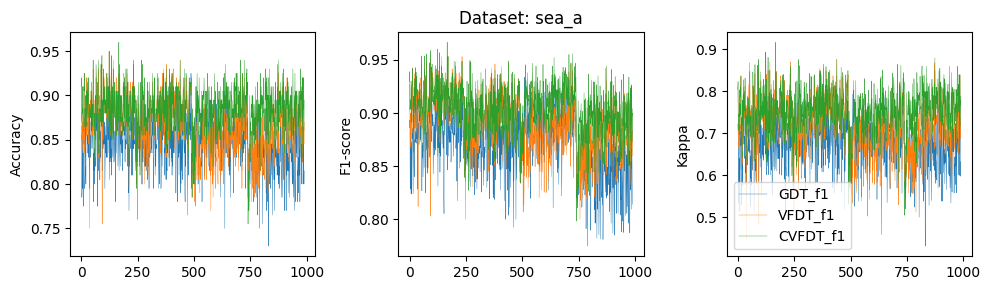

In [12]:
#Pairplot


X = np.arange(0, len(scores_GDT['acc']), 1)
with plt.style.context('default'):
 
    # Assign variables to the y axis part of the curve
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

    fig.tight_layout()

    # Plotting both the curves simultaneously
    axes[0].plot(X, scores_GDT['acc'],  label='GDT Acc', linewidth=0.3)
    axes[0].plot(X, scores_VFDT['acc'], label='VFDT Acc', linewidth=0.3)
    axes[0].plot(X, scores_CVFDT['acc'],  label='CVFDT Acc', linewidth=0.3)

    axes[1].plot(X, scores_GDT['f1'],  label='GDT_f1', linewidth=0.3)
    axes[1].plot(X, scores_VFDT['f1'], label='VFDT_f1', linewidth=0.3)
    axes[1].plot(X, scores_CVFDT['f1'], label='CVFDT_f1', linewidth=0.3)

    axes[2].plot(X, scores_GDT['kappa'], label='GDT_f1', linewidth=0.3)
    axes[2].plot(X, scores_VFDT['kappa'], label='VFDT_f1', linewidth=0.3)
    axes[2].plot(X, scores_CVFDT['kappa'], label='CVFDT_f1', linewidth=0.3)

    # Naming the x-axis, y-axis and the whole graph
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("F1-score")
    axes[2].set_ylabel("Kappa")
    axes[1].set_title("Dataset: " + dataset_name)
    plt.legend()
plt.tight_layout()
plt.savefig('results/'+dataset_name+'/lineplots_'+dataset_name+'.png', dpi = 300.0)
plt.show()


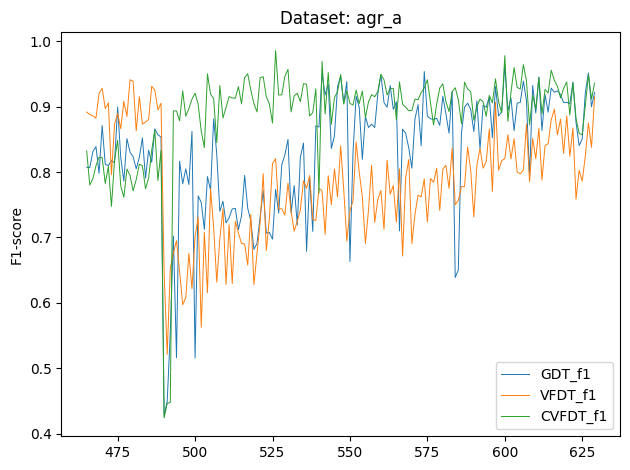

In [9]:
X = np.arange(465, 630, 1)
with plt.style.context('default'):
 
    # Assign variables to the y axis part of the curve
    #fig, axes = plt.figure(figsize=(10, 3))

    #fig.tight_layout()

    # Plotting both the curves simultaneously

    plt.plot(X, scores_GDT['f1'][465:630],  label='GDT_f1', linewidth=0.7) #465, 630
    plt.plot(X, scores_VFDT['f1'][465:630], label='VFDT_f1', linewidth=0.7)
    plt.plot(X, scores_CVFDT['f1'][465:630], label='CVFDT_f1', linewidth=0.7)

    # Naming the x-axis, y-axis and the whole graph
    plt.ylabel("F1-score")
    plt.title("Dataset: " + dataset_name)
    plt.legend()
plt.tight_layout()
plt.savefig('results/'+dataset_name+'/lineplots_'+dataset_name+'_zoom3.png', dpi = 300.0)
plt.show()

In [24]:
scores_GDT['f1'][220:300]

array([0.92913386, 0.93548387, 0.91390728, 0.9261745 , 0.90225564,
       0.91034483, 0.90361446, 0.95035461, 0.92537313, 0.89655172,
       0.92517007, 0.91935484, 0.89705882, 0.94964029, 0.92957746,
       0.95774648, 0.95384615, 0.8852459 , 0.93939394, 0.88571429,
       0.49180328, 0.50485437, 0.44334975, 0.49756098, 0.5412844 ,
       0.54054054, 0.5826087 , 0.59919028, 0.42857143, 0.54464286,
       0.6473029 , 0.36363636, 0.67910448, 0.63673469, 0.78087649,
       0.71936759, 0.75      , 0.81454545, 0.74545455, 0.70754717,
       0.71774194, 0.76348548, 0.79497908, 0.71818182, 0.78703704,
       0.77419355, 0.66122449, 0.82068966, 0.7826087 , 0.76033058,
       0.79828326, 0.79215686, 0.76068376, 0.80816327, 0.7965368 ,
       0.79207921, 0.7699115 , 0.81512605, 0.82553191, 0.81415929,
       0.86111111, 0.83035714, 0.74008811, 0.81355932, 0.8115942 ,
       0.78414097, 0.80357143, 0.8       , 0.77777778, 0.81102362,
       0.82051282, 0.85483871, 0.81690141, 0.81171548, 0.85454

In [ ]:
#output performance
#Global:(Average, Median)  Sliding:() 
results = pd.DataFrame(columns=['Metric','Operation','GDT','VFDT','CVFDT'])
results.loc[len(results)] = ['f1','median',round(np.median(scores_GDT['f1']),4),round(np.median(scores_VFDT['f1']),4),round(np.median(scores_CVFDT['f1']),4)]
results.loc[len(results)] = ['f1','average',round(np.average(scores_GDT['f1']),4),round(np.average(scores_VFDT['f1']),4),round(np.average(scores_CVFDT['f1']),4)]
results.loc[len(results)] = ['f1','std',round(np.std(scores_GDT['f1']),4),round(np.std(scores_VFDT['f1']),4),round(np.std(scores_CVFDT['f1']),4)]

results.loc[len(results)] = ['accuracy','median',round(np.median(scores_GDT['acc']),4),round(np.median(scores_VFDT['acc']),4),round(np.median(scores_CVFDT['acc']),4)]
results.loc[len(results)] = ['accuracy','average',round(np.average(scores_GDT['acc']),4),round(np.average(scores_VFDT['acc']),4),round(np.average(scores_CVFDT['acc']),4)]
results.loc[len(results)] = ['accuracy','std',round(np.std(scores_GDT['acc']),4),round(np.std(scores_VFDT['acc']),4),round(np.std(scores_CVFDT['acc']),4)]


results.loc[len(results)] = ['training time','total',round(timer['training']['GDT'],4),round(timer['training']['VFDT'],4),round(timer['training']['CVFDT'],4)]
results.loc[len(results)] = ['prediction time','total',round(timer['prediction']['GDT'],4),round(timer['prediction']['VFDT'],4),round(timer['prediction']['CVFDT'],4)]


In [67]:
results

,Metric,Operation,GDT,VFDT,CVFDT
0,f1,median,0.6115,0.6111,0.6131
1,f1,average,0.6047,0.6107,0.5909
2,f1,std,0.0521,0.0594,0.0869
3,accuracy,median,0.7050,0.7050,0.7550
4,accuracy,average,0.7044,0.6985,0.7550
5,accuracy,std,0.0398,0.0590,0.0430
6,training time,total,34.3869,1.1644,4.0044
7,prediction time,total,0.3349,0.1738,0.2063


In [81]:
results

,Metric,Operation,GDT,VFDT,CVFDT
0,f1,median,0.6115,0.6111,0.6131
1,f1,average,0.6047,0.6107,0.5909
2,f1,std,0.0521,0.0594,0.0869
3,accuracy,median,0.7050,0.7050,0.7550
4,accuracy,average,0.7044,0.6985,0.7550
5,accuracy,std,0.0398,0.0590,0.0430
6,training time,total,35.3875,1.1645,4.1193
7,prediction time,total,0.3577,0.1698,0.2110


In [56]:
VFDT_Hyperparamas = str(VFDT_classifier.get_info())
f = open('results/'+dataset_name+'/VFDT_Hyperparamas'+dataset_name+".txt", "w")
f.write(VFDT_Hyperparamas)
f.close()

In [57]:
CVFDT_Hyperparamas = str(CVFDT_classifier.get_info())
f = open('results/'+dataset_name+'/CVFDT_Hyperparamas'+dataset_name+".txt", "w")
f.write(CVFDT_Hyperparamas)
f.close()

In [45]:
#Parameters GDT
#Dataset Name, depth, 'lr index', 'lr values', 'lr leaf', 'optimizer', 'batch size', 'pretrain_size', 'pretrain_epochs'
GDT_Hyperparameters = pd.DataFrame(columns=['Dataset Name','depth','lr index', 'lr values', 'lr leaf', 'optimizer', 'batch size', 'pretrain_size', 'pretrain_epochs'])
GDT_Hyperparameters.loc[len(GDT_Hyperparameters)] = [dataset_name, config['gdt']['depth'],config['gdt']['learning_rate_index'],config['gdt']['learning_rate_values']
                                                    ,config['gdt']['learning_rate_leaf'],config['gdt']['optimizer'], config['gdt']['batch_size'],
                                                    config['computation']['pretrain_size'],
                                                    config['gdt']['pretrain_epochs']]
GDT_Hyperparameters.to_csv('results/'+dataset_name+'/VFDT_Hyperparamas'+dataset_name+".csv")


In [33]:
import seaborn as sns
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
df = pd.DataFrame({'GDT': scores_GDT['f1'],'VFDT': scores_VFDT['f1'],'CVFDT': scores_CVFDT['f1']})

sns.set(style="darkgrid")

sns.boxplot(x="Test", y=df['GDT'])
plt.show()

ValueError: Could not interpret input 'Test'